# Part 3F: Final Plots

The code that generated the final plots in the presentation is presented here. Each code block is complete, with all the code needed to read the data, do the curve fit, calculate the thermodynamic parameters and make the plot. This is the place to come wehn your ready to steal this code.

## Setup

In [2]:
### Setup environment

!mkdir plots

### Install and load packages
 
#!pip install uncertainties     # uncomment to install dependancy
#!pip install lmfit             # for docs see https://lmfit.github.io/lmfit-py/


import lmfit

from scipy.optimize import curve_fit     # tool for curve fitting
import scipy                             # includes tools for data analysis
import scipy.stats
import numpy as np                       # import the tools of NumPy 
from matplotlib import pyplot as plt     # tools for plotting
import pandas as pd

import uncertainties as un               # tool set for handling  uncertainties
from uncertainties import unumpy as unp  # a replacement for numpy 

### Set global variables

location_data = "data/"         ## Use either local folder or github folder. 
location_styles = "styles/"     ## Use github locations for Colab
#location_data = "https://raw.githubusercontent.com/blinkletter/PythonPresentation/main/data/"
#location_styles = "https://raw.githubusercontent.com/blinkletter/PythonPresentation/main/styles/"

size = [4,4]
size2 = [4,5]
size3 = [2.5,2.5]


mkdir: plots: File exists


## The Data Files

With the command below we send a command out to the shell and access the operating system. We used the `cat` command that prints the contents of a file to output.

In [3]:
### print data file 
# 
!cat data/Eryingdata3.csv   # use for local files

#import requests              # use for github files in colab
#url = location_data + "Eryingdata1.csv"
#response = requests.get(url)
#data = response.text
#for line in data.split('\n'):
#    print(line)

# from "Linear Eyring Plots Conceal a Change in the Rate-Limiting Step in an Enzyme Reaction"
# Teresa F. G. Machado, Tracey M. Gloster, and Rafael G. da Silva
# Biochemistry 2018 57 (49), 6757-6761
# https://doi.org/10.1021/acs.biochem.8b01099
#
# data for Figure 1: PaHBDH with Acetoacetate 
"TEMP(K)", "Kcat(s-1)", "Error(s-1)"
283,    30,    1
288,    42,    1
293,    60,    3
298,    86,    4
303,    112,   5 
308,    155,   4 
313,    172,   3 
318,    216,   8 

## Curve_Fit

This code used the `scipy.optimize.curve_fit` function to analyze the data. The confidence interval is based on the standard deviation. $2\sigma$ represents 95% confidence for the confidence interval.

,TEMP(K),Kcat(s-1),Error(s-1)
0,283,30,1
1,288,42,1
2,293,60,3
3,298,86,4
4,303,112,5
5,308,155,4
6,313,172,3
7,318,216,8


slope = -4848.39+/-204.96
intercept = 14.93+/-0.68
rsq = 0.988
The change in enthalpy is 40311.72+/-1704.11 kJ/mole
The change in entropy is -73.39+/-5.64 J/mole.K
Calculated k at T = 310 K is 152.90+/-4.82 s^-1


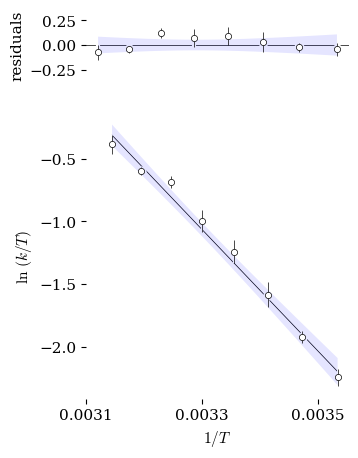

In [4]:
#### Eyring Plot with linear curve_fit

######################
### Read in data set
######################

datafile = "Eryingdata1.csv"   # change this file for new data
datafile = "Eryingdata2.csv"   # change this file for new data
datafile = "Eryingdata3.csv"   # change this file for new data
#datafile = "Eryingdata4.csv"   # change this file for new data

data = pd.read_csv(location_data+datafile, 
                 delimiter = ",", 
                 skipinitialspace=True, 
#                 index_col="TEMP(K)", 
                 comment = "#") 
display(data)

######################
### Experimental data with error
######################

temp = data["TEMP(K)"]       # list of temperatures
k_obs = data["Kcat(s-1)"]      # list of observe rate constants (s^-1)
k_obs_err = data["Error(s-1)"]  # list of standard deviations for data

### Convert lists to numpy arrays (enables numpy math tools with these lists)
temp = np.array(temp)
k_obs_u = unp.uarray(k_obs, k_obs_err)   # make an array of ufloat values

### Calculations for Erying plot axes
x = 1/temp
y_u = unp.log(k_obs_u/temp)   # y_u is now an array of ufloats

y = unp.nominal_values(y_u) # extract arrays of nominal values and errors
y_err = unp.std_devs(y_u)   # because curve_fit can handle ufloats

######################
###  Linear function to be used by curve_fit
######################
def linear(x, m, b):
    y = m * x + b
    return y

### Use curve_fit function           
popt, pcov = curve_fit(linear, x, y, sigma = y_err)  # use exp error

### Create new ufloat objects from returned parameters and covariance matrix 
(slope, intercept) = un.correlated_values(popt, pcov)

### print a report using the variables
print(f"slope = {slope:0.2f}")  
print(f"intercept = {intercept:0.2f}")  

r,p = scipy.stats.pearsonr(x,y)
rsq = r ** 2
print(f"rsq = {rsq:0.3f}")

######################
### calculate thermodynamic parameters
######################

R = scipy.constants.R
kb = scipy.constants.k
h = scipy.constants.h
kappa = 1

dH = -slope * R
dS = (intercept - np.log(kb/h)) * R

print(f"The change in enthalpy is {dH:0.2f} kJ/mole")
print(f"The change in entropy is {dS:0.2f} J/mole.K")

## calculate k from Erying plot parameters.
Temp = 310
kobs = (kappa * kb / h) * Temp * unp.exp(-dH/(R*Temp)) * unp.exp(dS/R)
print(f"Calculated k at T = {Temp} K is {kobs:0.2f} s^-1")

###############################################################################
######################
### Plots - NEW STYLED PLOTTING SECTION
######################

plt.rcdefaults()

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=size2, height_ratios=[1, 4])  

# Settings for plot
ax[1].set(
#          teitle = Title,       
          ylabel=r"$\ln\,\left(k/T\right)$ ", 
          xlabel=r"$1/T$",                
#          xlim=[0, np.max(x) + np.max(x) * 0.1],                  
#          ylim=[None,None]
       )

### White background graphics
ax[1].scatter(x, y, marker = "o", s = 40, color = "white", zorder = 2)
### Data graphics
ax[1].scatter(x, y, marker = "o", s = 20, 
              color = "white", edgecolors = "black", 
              linewidths=0.5, zorder = 4) 


### calculate y-values using best fit parameters
x_0 = np.linspace(np.min(x),np.max(x),100)       # for plotting from zero
best_fit_y = linear(x_0, slope, intercept)     # uncertain array of line fit

# Plot the curve fit line
ax[1].plot(x_0,unp.nominal_values(best_fit_y), 
           marker = None, color = "black", 
           linewidth=0.5, zorder = 0)


######################
#### Create Confidence band upper and lower bounds
######################
sigma = 2

# upper and lower bounds of uncertain kobs as float values
fit_up = unp.nominal_values(best_fit_y) + unp.std_devs(best_fit_y) * sigma
fit_dn = unp.nominal_values(best_fit_y) - unp.std_devs(best_fit_y) * sigma

# make filled band
ax[1].fill_between(x_0, fit_up, fit_dn, 
                   facecolor="blue", alpha=0.1, zorder = 2,
                   label="confidence interval")

# Add error bars
### White background graphics
ax[1].errorbar(x, y, yerr=y_err*sigma, xerr=None, fmt="None", 
               ecolor="white", elinewidth=1.5, dash_capstyle="round",
               zorder=1)
### Data graphics
ax[1].errorbar(x, y, yerr=y_err*sigma, xerr=None, fmt="None", 
               ecolor="black", elinewidth=0.5, 
             #  capsize=2, capthick=0.5, 
               zorder=3)

ax[1].set_xticks([0.0031,0.0033,0.0035])


######################
### Plot the residuals
######################

# difference between data and line-fit
residuals = y - linear(x, slope.n, intercept.n)      

ax[0].set(
#          title = Title,       
          ylabel=r"residuals", 
          xlabel=r"",                
#          xlim=[0, np.max(x) + np.max(x) * 0.1],                  
          ylim=[-np.max(residuals)*3,np.max(residuals)*3]
       )
### White background Graphics
ax[0].scatter(x, residuals, marker = "o", s = 40, color = "white", zorder = 1)
ax[0].errorbar(x, residuals, yerr=y_err*sigma, xerr=None, fmt="None", 
               ecolor="white", elinewidth=3, zorder=1)
### Data graphics
ax[0].scatter(x, residuals, marker = "o", s = 20, 
              color = "white", edgecolors = "black", 
              linewidths=0.5, zorder = 3)
ax[0].errorbar(x, residuals, yerr=y_err*sigma, xerr=None, fmt="None", 
               ecolor="black", elinewidth=0.5, dash_capstyle="projecting",
             #  capsize=2, capthick=0.5, 
               zorder=2)

# make filled band
ax[0].fill_between(x_0, unp.std_devs(best_fit_y) * sigma, -unp.std_devs(best_fit_y) * sigma, 
                   facecolor="blue", alpha=0.1, zorder = 1,
                   linewidth = 0, label="confidence interval")

### Other elements
ax[0].axhline(0, color='black', linewidth=0.5, zorder = 0) 
ax[0].set_xticks([])


### Output plot
plt.tight_layout(pad=2, h_pad=None, w_pad=None, rect=None)
plt.savefig("plots/3F-1.pdf")
plt.show()


## LMfit

The code below uses tools ion the `lmfit` package to analyze the data.  The condience interval is that reported by the `lmfit` result object. I then used the correlation between the slope and intercept and the 95% confidence interval as the error to construct new uncertain values for those parameters. the the error propagation produced value for $\Delta H^\ddagger$ and $\Delta S^\ddagger$ with errors.

There are two plots. One is made using the `lmfit` plotting tools and the other is  made using `matplotlib` directly so that I could have more control over styling the plot.

,TEMP(K),Kcat(s-1),Error(s-1)
0,283,30,1
1,288,42,1
2,293,60,3
3,298,86,4
4,303,112,5
5,308,155,4
6,313,172,3
7,318,216,8


---------- FIT REPORT ------------
[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 8
    # variables        = 2
    chi-square         = 41.8144529
    reduced chi-square = 6.96907548
    Akaike info crit   = 17.2304040
    Bayesian info crit = 17.3892871
    R-squared          = 0.98724331
[[Variables]]
    m: -4848.38522 +/- 204.957047 (4.23%) (init = -1000)
    b:  14.9331896 +/- 0.67789322 (4.54%) (init = -1)
[[Correlations]] (unreported correlations are < 0.100)
    C(m, b) = -0.9992
RSQ = 0.988

      99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 m:-1005.12538-515.77934-223.51981-4848.38522+223.51981+515.77934+1005.12261
 b:  -3.32443  -1.70593  -0.73929  14.93319  +0.73929  +1.70593  +3.32444

 ------THERMODYNAMIC PARAMETERS - 1 sigma ---------
The change in enthalpy is 40311.72+/-1704.11 J/mole
The change in entropy is -73.39+/-5.64 J/mole.K

-------- CHECK FIT ----------
c

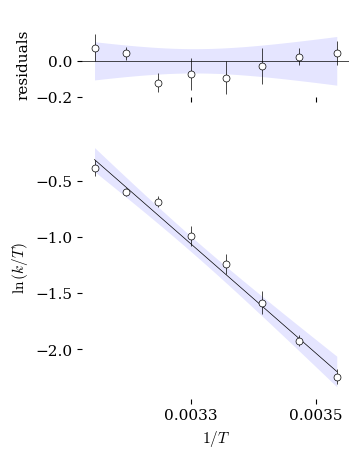

------------------------------------
---- Calc Thermo Params 95% CI -----
------------------------------------
(-4.8+/-0.5)e+03
14.9+/-1.7
The change in enthalpy is 40311.72+/-4288.43 kJ/mole
The change in entropy is -73.39+/-14.18 J/mole.K
Calculated k at T = 310 K is 152.90+/-12.12 s^-1


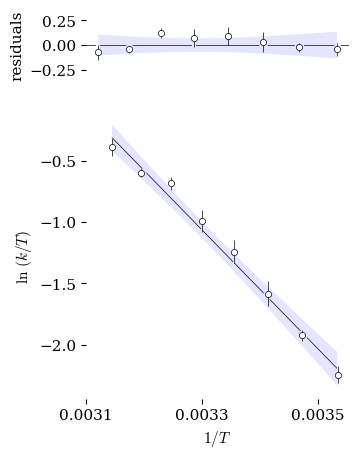

In [6]:
### LMFit

######################
### Read in data set
######################

datafile = "Eryingdata1.csv"   # change this file for new data
datafile = "Eryingdata2.csv"   # change this file for new data
datafile = "Eryingdata3.csv"   # change this file for new data
#datafile = "Eryingdata4.csv"   # change this file for new data

data = pd.read_csv(location_data+datafile, 
                 delimiter = ",", 
                 skipinitialspace=True, 
#                 index_col="TEMP(K)", 
                 comment = "#") 
display(data)

######################
### Experimental data with error
######################

temp = data["TEMP(K)"]       # list of temperatures
k_obs = data["Kcat(s-1)"]      # list of observe rate constants (s^-1)
k_obs_err = data["Error(s-1)"]  # list of standard deviations for data

### Convert lists to numpy arrays (enables numpy math tools with these lists)
temp = np.array(temp)
k_obs_u = unp.uarray(k_obs, k_obs_err)   # make an array of ufloat values

### Calculations for Erying plot axes
x = 1/temp
y_u = unp.log(k_obs_u/temp)   # y_u is now an array of ufloats

y = unp.nominal_values(y_u) # extract arrays of nominal values and errors
y_err = unp.std_devs(y_u)   # because curve_fit can handle ufloats

######################
###  Linear function to be used by curve_fit
######################
def linear(x, m, b):
    y = m * x + b
    return y

### Use curve_fit function  

# load the function f as the model to be fit
mod = lmfit.Model(linear)       

# state the parameters (use the text strings that we used above in the 
#   function) initial values are also set here
pars = mod.make_params(m=-1000, b=-1  )     
                                            
# use the .fit method on the model object to perform the curve fit
result = mod.fit(y, pars, x=x, weights=1.0/y_err)   


print("---------- FIT REPORT ------------")
print(result.fit_report())

r,p = scipy.stats.pearsonr(x,y); rsq = r**2
print(f"RSQ = {rsq:0.3f}")
print()

#print("--- PARAMETER CONFIDENCE INTERVALS ----")
print(result.ci_report())
#print()

intercept = result.uvars['b']      # collect parameters as uncertain values 
slope = result.uvars['m']

Temp = 310
R = scipy.constants.R
kb = scipy.constants.k
h = scipy.constants.h
kappa = 1

dH = -slope * R
dS = (intercept - np.log(kb/h)) * R

print("\n ------THERMODYNAMIC PARAMETERS - 1 sigma ---------")
print(f"The change in enthalpy is {dH:0.2f} J/mole")
print(f"The change in entropy is {dS:0.2f} J/mole.K")
print()

## calculate k from Erying plot parameters.
kobs = (kappa * kb / h) * Temp * unp.exp(-dH/(R*Temp)) * unp.exp(dS/R)
print("-------- CHECK FIT ----------")
print(f"calculate k at T={Temp} K is {kobs:0.2f}")

### PLOT

plt.rcdefaults()
style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = location_styles + style
plt.style.use(style_name)

#intercept = result.uvars['b']      # collect parameters as uncertain values 
#slope = result.uvars['m']

fig = plt.figure(figsize = size2)
result.plot(fig = fig,
            fig_kws = {},      # this is a keyword dictionary for figure styles
            xlabel = r"$1/T$",
            ylabel = r"$\ln \left( k/T \right)$",
            yerr = 2*y_err,
            title = " ",
            data_kws ={"color":"black", "linestyle":"None", "linewidth": 0.5,
                       "markerfacecolor": "white", "markeredgecolor":"black", "markersize":5,
                       "markeredgewidth":0.5, "zorder":3},
            fit_kws ={"linewidth": 0.5, "zorder":2},
            ax_res_kws = {},   # 'kws' is 'keyword styles'
            ax_fit_kws = {},
            )
 
ax = fig.axes   # get the axes from the plot (there are two in a list)

ax[1].set_xticks([0.0031,0.0033,0.0035]) # These will be the ticks for both axes

### Confidence band
sigma = 2

x_0 = np.linspace(np.min(x), np.max(x), 100)
y_0 = result.eval(x=x_0)
dely = result.eval_uncertainty(x=x)
dely_0 = result.eval_uncertainty(x=x_0, sigma=sigma)

ax[1].fill_between(x_0, y_0-dely_0, y_0+dely_0, 
                   linewidth=0, color='blue', alpha = 0.1, zorder=1
                   )
ax[0].fill_between(x_0, -dely_0, dely_0, 
                   linewidth=0, color='blue', alpha = 0.1, zorder=1
                   )

### do not show legend 
#fig.legend([])
ax[1].legend([])      # blank legend

plt.tight_layout(pad=2, h_pad=None, w_pad=None, rect=None)
plt.savefig("plots/3F-2.pdf")
plt.show()


print("------------------------------------")
print("---- Calc Thermo Params 95% CI -----")
print("------------------------------------")

slope_ci95 = result.ci_out["m"][1][1] - result.ci_out["m"][3][1]
int_ci95 = result.ci_out["b"][1][1] - result.ci_out["b"][3][1]
slope_best = result.ci_out["m"][3][1]
int_best = result.ci_out["b"][3][1]

# I want to use the correlation matrix for the results.uvars parameters
#  but I want to use the 95% confidence interval as the error.

# make correlation matrix from the uvars (note correlation matrix is 
#  different than covariance matrix)

corr_matrix = un.correlation_matrix([result.uvars["m"], result.uvars["b"]])

(slope, intercept) = un.correlated_values_norm([(slope_best,slope_ci95),
                                               (int_best, int_ci95)],
                                               corr_matrix)

print(slope)
print(intercept)

### calculate thermodynamic parameters
R = scipy.constants.R
kb = scipy.constants.k
h = scipy.constants.h
kappa = 1

dH = -slope * R
dS = (intercept - np.log(kb/h)) * R

print(f"The change in enthalpy is {dH:0.2f} kJ/mole")
print(f"The change in entropy is {dS:0.2f} J/mole.K")

## calculate k from Erying plot parameters.
Temp = 310
kobs = (kappa * kb / h) * Temp * unp.exp(-dH/(R*Temp)) * unp.exp(dS/R)
print(f"Calculated k at T = {Temp} K is {kobs:0.2f} s^-1")




###############################################################################
######################
### Plots - NEW STYLED PLOTTING SECTION
######################

plt.rcdefaults()

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=size2, height_ratios=[1, 4])  

# Settings for plot
ax[1].set(
#          teitle = Title,       
          ylabel=r"$\ln\,\left(k/T\right)$ ", 
          xlabel=r"$1/T$",                
#          xlim=[0, np.max(x) + np.max(x) * 0.1],                  
#          ylim=[None,None]
       )

### White background graphics
ax[1].scatter(x, y, marker = "o", s = 40, color = "white", zorder = 2)
### Data graphics
ax[1].scatter(x, y, marker = "o", s = 20, 
              color = "white", edgecolors = "black", 
              linewidths=0.5, zorder = 4) 


### calculate y-values using best fit parameters
x_0 = np.linspace(np.min(x),np.max(x),100)       # for plotting from zero
best_fit_y = linear(x_0, slope, intercept)     # uncertain array of line fit

# Plot the curve fit line
ax[1].plot(x_0,unp.nominal_values(best_fit_y), 
           marker = None, color = "black", 
           linewidth=0.5, zorder = 0)


######################
#### Create Confidence band upper and lower bounds
######################
sigma = 2

# upper and lower bounds of uncertain kobs as float values
fit_up = unp.nominal_values(best_fit_y) + unp.std_devs(best_fit_y)
fit_dn = unp.nominal_values(best_fit_y) - unp.std_devs(best_fit_y)

# make filled band
ax[1].fill_between(x_0, fit_up, fit_dn, 
                   facecolor="blue", alpha=0.1, zorder = 2,
                   label="confidence interval")

# Add error bars
### White background graphics
ax[1].errorbar(x, y, yerr=y_err*sigma, xerr=None, fmt="None", 
               ecolor="white", elinewidth=1.5, dash_capstyle="round",
               zorder=1)
### Data graphics
ax[1].errorbar(x, y, yerr=y_err*sigma, xerr=None, fmt="None", 
               ecolor="black", elinewidth=0.5, 
             #  capsize=2, capthick=0.5, 
               zorder=3)

ax[1].set_xticks([0.0031,0.0033,0.0035])


######################
### Plot the residuals
######################

# difference between data and line-fit
residuals = y - linear(x, slope.n, intercept.n)      

ax[0].set(
#          title = Title,       
          ylabel=r"residuals", 
          xlabel=r"",                
#          xlim=[0, np.max(x) + np.max(x) * 0.1],                  
          ylim=[-np.max(residuals)*3,np.max(residuals)*3]
       )
### White background Graphics
ax[0].scatter(x, residuals, marker = "o", s = 40, color = "white", zorder = 1)
ax[0].errorbar(x, residuals, yerr=y_err*sigma, xerr=None, fmt="None", 
               ecolor="white", elinewidth=3, zorder=1)
### Data graphics
ax[0].scatter(x, residuals, marker = "o", s = 20, 
              color = "white", edgecolors = "black", 
              linewidths=0.5, zorder = 3)
ax[0].errorbar(x, residuals, yerr=y_err*sigma, xerr=None, fmt="None", 
               ecolor="black", elinewidth=0.5, dash_capstyle="projecting",
             #  capsize=2, capthick=0.5, 
               zorder=2)

# make filled band
ax[0].fill_between(x_0, unp.std_devs(best_fit_y) , -unp.std_devs(best_fit_y) , 
                   facecolor="blue", alpha=0.1, zorder = 1,
                   linewidth = 0, label="confidence interval")

### Other elements
ax[0].axhline(0, color='black', linewidth=0.5, zorder = 0) 
ax[0].set_xticks([])


### Output plot
plt.tight_layout(pad=2, h_pad=None, w_pad=None, rect=None)
plt.savefig("plots/3F-2B.pdf")
plt.show()


## Bootstrap

The code below uses the bootstrap algorithm to calculate thousands of curve fits. The 95% condidence band is constructed.

Confidence level = 95.5%

slope range is -5545.3 to -6048.7
median slope in bootstrap population is -5824.6 + 279.3 - 224.0
best fit value for slope is -5857.9+/-89.3

intercept range is 16.95 to 15.32
median intercept in bootstrap population is 16.22 + 0.73 - 0.90
best fit value for intercept is 16.34+/-0.29

delta H range is 46106.14 to 50291.40
median delta H in bootstrap population is 48428.72 + 1862.68 - 2322.58
best fit value for delta H is 48705.16+/-742.32

delta S range is -70.19 to -56.60
median delta S in bootstrap population is -62.68 + 6.09 - 7.50
best fit value for delta S is -61.69+/-2.45



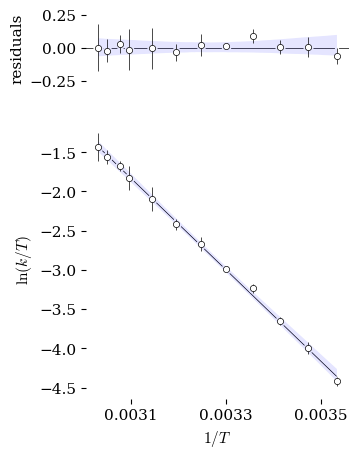

In [7]:
sigma_value = 2

y_lim_1 = [-3.8,-2.2]
x_lim_1 = [0.00318,0.00342]
y_lim_2 = [-7, 18.0]
x_lim_2 = [-0.0002, 0.0036]
y_ticks_1 = [-3.6,-3.2,-2.8,-2.4]
#y_ticks_1 = [-3.8,-3.4,-3.0,-2.6,-2.2]
y_ticks_2 = []
x_ticks_1 = [0.0031,0.0033,0.0035]
x_ticks_2 = [0,0.001,0.002,0.003]



######################
### Read in data set
######################

datafile = "Eryingdata1.csv"   # change this file for new data
#datafile = "Eryingdata2.csv"   # change this file for new data
#datafile = "Eryingdata3.csv"   # change this file for new data
#datafile = "Eryingdata4.csv"   # change this file for new data

data = pd.read_csv(location_data+datafile, 
                 delimiter = ",", 
                 skipinitialspace=True, 
#                 index_col="TEMP(K)", 
                 comment = "#") 
#display(data)

######################
### Experimental data with error
######################

temp = data["TEMP(K)"]       # list of temperatures
k_obs = data["Kcat(s-1)"]      # list of observe rate constants (s^-1)
k_obs_err = data["Error(s-1)"]  # list of standard deviations for data

### Convert lists to numpy arrays (enables numpy math tools with these lists)
temp = np.array(temp)
k_obs_u = unp.uarray(k_obs, k_obs_err)   # make an array of ufloat values

### Calculate x, y values and the uncertainty y_err using the
###   error propagation provided by the *uncertainties* package

x = 1/temp                        # 1/T
y_u = unp.log(k_obs_u/temp)             # ln(k/T) uncertain array for y-axis

### Separate the uncertain y value into y and y_err for use in the curve_fit 

y = unp.nominal_values(y_u)       # extract arrays of nominal values and errors
y_err = unp.std_devs(y_u)         #   because curve_fit can't handle ufloats


################################################################################
### SMOOTH BOOTSTRAP 
### 
### Adapted from code found in https://stats.stackexchange.com/questions/183230/bootstrapping-confidence-interval-from-a-regression-prediction
################################################################################

#######################################
## Global variables
#######################################

sigma = sigma_value       # Confidence. 1 sigma:68%, 2 sigma:95.5%, 3 sigma:99.7$
boot_n = 2000             # Number of bootstrap resamples

#######################################
## Define confidence percentile limits
#######################################

sigma_dict = {1:68.3, 2:95.5, 3:99.7}      

conf = sigma_dict[sigma]
low_p = 50 - conf/2
high_p = 50 + conf/2

#######################################
## Set up functions for curve fit and thermodynamic calculations
#######################################

def linear(x, slope, intercept):     # Linear function for line fitting
    return slope * x + intercept

def eyring_calc(slope, intercept):   # Calculate thermodynamic parameters
    R = scipy.constants.R
    kb = scipy.constants.k
    h = scipy.constants.h
    kappa = 1
    
    dH = -slope * R
    dS = (intercept - unp.log(kb/h)) * R
    return dH, dS

#######################################
## Bootstrap - Calculate a list of line fits for resampled data sets.
#######################################

slope_list = []           # A list of slopes from each iteration of bootstrap
intercept_list = []       # A list of intercepts

dS_list = []
dH_list = []

x_for_ci = np.linspace(np.min(x), np.max(x), 100)   # Array of x values 

y_list = []             # A list of predicted values at each data point
y_for_ci = []           # A list of sets of predicted values at each x point                     

for i in range(0, boot_n):
    pick = np.random.choice(range(0, len(y)), len(y))  # Random data pick

    x_s = x[pick]             # Get x and y values from random pick
    y_s = np.random.normal(y[pick], y_err[pick])   # smooth with gaussian error 
    y_err_s = y_err[pick]

    popt,pcov = curve_fit(linear, x_s, y_s)    # Curve fit the resampled data

    [slope, intercept] = popt
    slope_list.append(slope)
    intercept_list.append(intercept)

    dH, dS = eyring_calc(slope, intercept)
    dH_list.append(dH)
    dS_list.append(dS)

    y_list.append(linear(x, *popt))            # Predict y at data points 
    y_for_ci.append(linear(x_for_ci, *popt))   # Predict y along data range 

# Convert these lists of arrays to arrays of arrays (a matrix)
y_list = np.array(y_list)
y_for_ci = np.array(y_for_ci)    

### Package up data into a dictionary object (for convenience)

bs = {
    "y_list": y_list,
    "x_for_ci": x_for_ci,
    "y_for_ci": y_for_ci,
    "slope_list": slope_list,
    "intercept_list": intercept_list,
    "dH_list": dH_list,
    "dS_list": dS_list
}

#######################################
## Traditional Curve Fit for Comparison
#######################################

popt,pcov = curve_fit(linear, x, y,        # Final curve fit of original data
                      sigma = y_err, absolute_sigma=False  # Include exp err
                     )

# Create new ufloat objects from returned parameters and covariance matrix 
[slope_u, intercept_u] = un.correlated_values(popt, pcov)

#######################################
### Report
#######################################
print(f"Confidence level = {conf}%")
print()

numbers = unp.nominal_values(bs["slope_list"])
top_slope = np.percentile(numbers, high_p)
bot_slope = np.percentile(numbers, low_p)
median_slope = np.median(numbers)

print(f"slope range is {top_slope:0.1f} to {bot_slope:0.1f}")
print(f"median slope in bootstrap population is {median_slope:0.1f} + "
      + f"{top_slope-median_slope:0.1f} - {median_slope-bot_slope:0.1f}"
      )
print(f"best fit value for slope is {slope_u:0.1f}")
print()

numbers = unp.nominal_values(bs["intercept_list"])
top_intercept = np.percentile(numbers, high_p)
bot_intercept = np.percentile(numbers, low_p)
median_intercept = np.median(numbers)

print(f"intercept range is {top_intercept:0.2f} to {bot_intercept:0.2f}")
print(f"median intercept in bootstrap population is {median_intercept:0.2f} + "
      + f"{top_intercept-median_intercept:0.2f} - "
      + f"{median_intercept-bot_intercept:0.2f}"
      )
print(f"best fit value for intercept is {intercept_u:0.2f}")
print()

dH, dS = eyring_calc(slope_u, intercept_u)

numbers = unp.nominal_values(bs["dH_list"])
top_dH = np.percentile(numbers, high_p)
bot_dH = np.percentile(numbers, low_p)
median_dH = np.median(numbers)

print(f"delta H range is {bot_dH:0.2f} to {top_dH:0.2f}")
print(f"median delta H in bootstrap population is {median_dH:0.2f} + " 
      + f"{top_dH-median_dH:0.2f} - {median_dH-bot_dH:0.2f}"
      )
print(f"best fit value for delta H is {dH:0.2f}")
print()

numbers = unp.nominal_values(bs["dS_list"])
top_dS = np.percentile(numbers, high_p)
bot_dS = np.percentile(numbers, low_p)
median_dS = np.median(numbers)

print(f"delta S range is {bot_dS:0.2f} to {top_dS:0.2f}")
print(f"median delta S in bootstrap population is {median_dS:0.2f} + "
      + f"{top_dS-median_dS:0.2f} - {median_dS-bot_dS:0.2f}")
print(f"best fit value for delta S is {dS:0.2f}")
print()


#######################################
### Create plot
#######################################
plt.rcdefaults()

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = location_styles + style
plt.style.use(style_name)

size = [4,4]
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=size2, height_ratios=[1, 4])  

ax[1].set(
#          title = Title,       
          ylabel=r"$\ln (k / T)$", 
          xlabel=r"$1/T$",                
 #         xlim = x_lim_1,                  
 #         ylim = y_lim_1,
          xticks = x_ticks_1,
 #         yticks = y_ticks_1
       )

### White background Graphics
ax[1].scatter(x, y, marker = "o", s = 40, color = "white", zorder = 1)
ax[1].errorbar(x, y, yerr=y_err*sigma, xerr=None, fmt="None", 
               ecolor="white", elinewidth=3, zorder=1)
### Data graphics

ax[1].scatter(x,y, marker='o', s = 20, 
              color='white', edgecolor='black', linewidth = 0.5, zorder=4)

ax[1].errorbar(x, y, yerr=2*y_err, xerr=None, fmt="None", 
               ecolor="black", elinewidth=0.5, 
            #   capsize=2, capthick=0.5, 
               zorder=3)

#######################################
### Plot Best Fit
#######################################

y_axis_for_ci = linear(x_for_ci, median_slope, median_intercept)
ax[1].plot(x_for_ci, y_axis_for_ci, 
           color='black', linewidth = 0.5, zorder=0)


#######################################
### Interval
#######################################
top_y = []
bot_y = []
med_y = []

for n in range(len(x_for_ci)):
    top_y.append(np.percentile(y_for_ci[:,n], high_p))
    bot_y.append(np.percentile(y_for_ci[:,n], low_p))
    med_y.append(np.percentile(y_for_ci[:,n], 50))

ax[1].fill_between(x_for_ci, top_y, bot_y, 
                   facecolor="blue", alpha=0.1, zorder = 2,
                   label="confidence interval")


#ax[1].plot(x_for_ci, med_y, 
#           color='red', linewidth = 0.5, zorder=0)


######################
### Plot the residuals
######################
# difference between data and line-fit
residuals = y - linear(x, median_slope, median_intercept)      

# difference between data and line-fit
residual_top = top_y - y_axis_for_ci      
residual_bot = bot_y - y_axis_for_ci     

ax[0].set(
#          title = Title,       
          ylabel=r"residuals", 
          xlabel=r"",                
#          xlim=[0, np.max(x) + np.max(x) * 0.1],                  
          ylim=[-np.max(residuals)*3,np.max(residuals)*3]
       )
### White background Graphics
ax[0].scatter(x, residuals, marker = "o", s = 40, color = "white", zorder = 1)
ax[0].errorbar(x, residuals, yerr=y_err*sigma, xerr=None, fmt="None", 
               ecolor="white", elinewidth=3, zorder=1)
### Data graphics
ax[0].scatter(x, residuals, marker = "o", s = 20, 
              color = "white", edgecolors = "black", 
              linewidths=0.5, zorder = 4)
ax[0].errorbar(x, residuals, yerr=y_err*sigma, xerr=None, fmt="None", 
               ecolor="black", elinewidth=0.5, dash_capstyle="projecting",
             #  capsize=2, capthick=0.5, 
               zorder=3)

# make filled band
ax[0].fill_between(x_for_ci, residual_top, residual_bot, 
                   facecolor="blue", alpha=0.1, zorder = 2,
                   linewidth = 0, label="confidence interval")

### Other elements
ax[0].axhline(0, color='black', linewidth=0.5, zorder = 0) 
ax[0].set_xticks([])



#######################################
### Output plot
#######################################
plt.tight_layout(pad=2, h_pad=None, w_pad=None, rect=None)

plt.savefig("plots/3F-3.pdf")
plt.show()




## Curve_Fit with non-linear equation

Let us repeat all of the above but with the non-linear version of the Erying equation.

,TEMP(K),Kcat(s-1),Error(s-1)
0,283,3.4,0.1
1,288,5.3,0.2
2,293,7.6,0.2
3,298,11.7,0.3
4,303,15.2,0.1
5,308,21.3,0.9
6,313,27.8,0.9
7,318,39.0,3.0
8,323,52.0,4.0
9,325,61.0,2.0


dH = 48761.09+/-717.54
dS = -61.51+/-2.37
rsq = 0.903
The change in enthalpy is 48761.09+/-717.54 kJ/mole
The change in entropy is -61.51+/-2.37 J/mole.K
Calculated k at T = 310 K is 24.05+/-0.24 s^-1


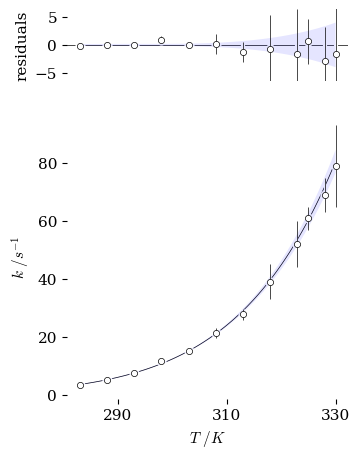

In [14]:
#### Eyring Plot with linear curve_fit

######################
### Read in data set
######################

datafile = "Eryingdata1.csv"   # change this file for new data
#datafile = "Eryingdata2.csv"   # change this file for new data
#datafile = "Eryingdata3.csv"   # change this file for new data
#datafile = "Eryingdata4.csv"   # change this file for new data

data = pd.read_csv(location_data+datafile, 
                 delimiter = ",", 
                 skipinitialspace=True, 
#                 index_col="TEMP(K)", 
                 comment = "#") 
display(data)

######################
### Experimental data with error
######################

temp = data["TEMP(K)"]       # list of temperatures
k_obs = data["Kcat(s-1)"]      # list of observe rate constants (s^-1)
k_obs_err = data["Error(s-1)"]  # list of standard deviations for data

### Convert lists to numpy arrays (enables numpy math tools with these lists)
temp = np.array(temp)
k_obs_u = unp.uarray(k_obs, k_obs_err)   # make an array of ufloat values

### Calculations for Erying plot axes
x = temp
y = unp.nominal_values(k_obs_u) # extract arrays of nominal values and errors
y_err = unp.std_devs(k_obs_u)   # because curve_fit can handle ufloats

######################
### function to be used by curve_fit
######################
def eyring(T, dH, dS):       # function for curve fit. No uncertainty allowed
    
    R = scipy.constants.R
    kb = scipy.constants.k
    h = scipy.constants.h
    kappa = 1

    y = (kappa * kb / h) * T * np.exp(-dH/(R*T)) * np.exp(dS/R)
    return y

def eyring_u(T, dH, dS):     # same function as above but uses uncertainty
                             # to be used when calculating confidence bands.
    R = scipy.constants.R
    kb = scipy.constants.k
    h = scipy.constants.h
    kappa = 1

    y = (kappa * kb / h) * T * unp.exp(-dH/(R*T)) * unp.exp(dS/R)
    return y

######################
### Use curve_fit function           
######################
popt, pcov = curve_fit(eyring, x, y, sigma = y_err)  # use exp error

### Create new ufloat objects from returned parameters and covariance matrix 
(dH, dS) = un.correlated_values(popt, pcov)

### print a report using the variables
print(f"dH = {dH:0.2f}")  
print(f"dS = {dS:0.2f}")  

r,p = scipy.stats.pearsonr(x,y)
rsq = r ** 2
print(f"rsq = {rsq:0.3f}")

######################
### calculate thermodynamic parameters
######################

print(f"The change in enthalpy is {dH:0.2f} kJ/mole")
print(f"The change in entropy is {dS:0.2f} J/mole.K")

## calculate k from Erying plot parameters.
Temp = 310
kobs = (kappa * kb / h) * Temp * unp.exp(-dH/(R*Temp)) * unp.exp(dS/R)
print(f"Calculated k at T = {Temp} K is {kobs:0.2f} s^-1")

###############################################################################
######################
### Plots - NEW STYLED PLOTTING SECTION
######################

plt.rcdefaults()

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=size2, height_ratios=[1, 4])  

# Settings for plot
ax[1].set(
#          teitle = Title,       
          ylabel=r"$k\ /s^{-1}$ ", 
          xlabel=r"$T\ /K$",                
#          xlim=[0, np.max(x) + np.max(x) * 0.1],                  
#          ylim=[None,None]
       )

### White background graphics
ax[1].scatter(x, y, marker = "o", s = 40, color = "white", zorder = 2)
### Data graphics
ax[1].scatter(x, y, marker = "o", s = 20, 
              color = "white", edgecolors = "black", 
              linewidths=0.5, zorder = 4) 


### calculate y-values using best fit parameters
x_0 = np.linspace(np.min(x),np.max(x),100)       # for plotting from zero
best_fit_y = eyring_u(x_0, dH, dS)     # uncertain array of line fit

# Plot the curve fit line
ax[1].plot(x_0,unp.nominal_values(best_fit_y), 
           marker = None, color = "black", 
           linewidth=0.5, zorder = 0)


######################
#### Create Confidence band upper and lower bounds
######################
sigma = 2

# upper and lower bounds of uncertain kobs as float values
fit_up = unp.nominal_values(best_fit_y) + unp.std_devs(best_fit_y) * sigma
fit_dn = unp.nominal_values(best_fit_y) - unp.std_devs(best_fit_y) * sigma

# make filled band
ax[1].fill_between(x_0, fit_up, fit_dn, 
                   facecolor="blue", alpha=0.1, zorder = 2,
                   label="confidence interval")

# Add error bars
### White background graphics
ax[1].errorbar(x, y, yerr=y_err*sigma, xerr=None, fmt="None", 
               ecolor="white", elinewidth=1.5, dash_capstyle="round",
               zorder=1)
### Data graphics
ax[1].errorbar(x, y, yerr=y_err*sigma, xerr=None, fmt="None", 
               ecolor="black", elinewidth=0.5, 
             #  capsize=2, capthick=0.5, 
               zorder=3)

ax[1].set_xticks([290,310,330])


######################
### Plot the residuals
######################

# difference between data and line-fit
residuals = y - eyring(x, dH.n, dS.n)      

ax[0].set(
#          title = Title,       
          ylabel=r"residuals", 
          xlabel=r"",                
#          xlim=[0, np.max(x) + np.max(x) * 0.1],                  
          ylim=[-np.max(residuals)*7,np.max(residuals)*7]
       )
### White background Graphics
ax[0].scatter(x, residuals, marker = "o", s = 40, color = "white", zorder = 1)
ax[0].errorbar(x, residuals, yerr=y_err*sigma, xerr=None, fmt="None", 
               ecolor="white", elinewidth=3, zorder=1)
### Data graphics
ax[0].scatter(x, residuals, marker = "o", s = 20, 
              color = "white", edgecolors = "black", 
              linewidths=0.5, zorder = 3)
ax[0].errorbar(x, residuals, yerr=y_err*sigma, xerr=None, fmt="None", 
               ecolor="black", elinewidth=0.5, dash_capstyle="projecting",
             #  capsize=2, capthick=0.5, 
               zorder=2)

# make filled band
ax[0].fill_between(x_0, unp.std_devs(best_fit_y) * sigma, -unp.std_devs(best_fit_y) * sigma, 
                   facecolor="blue", alpha=0.1, zorder = 1,
                   linewidth = 0, label="confidence interval")

### Other elements
ax[0].axhline(0, color='black', linewidth=0.5, zorder = 0) 
ax[0].set_xticks([])


### Output plot
plt.tight_layout(pad=2, h_pad=None, w_pad=None, rect=None)
plt.savefig("plots/3F-4.pdf")
plt.show()


## LMFit with non-linear plot

And again with LMfit

,TEMP(K),Kcat(s-1),Error(s-1)
0,283,3.4,0.1
1,288,5.3,0.2
2,293,7.6,0.2
3,298,11.7,0.3
4,303,15.2,0.1
5,308,21.3,0.9
6,313,27.8,0.9
7,318,39.0,3.0
8,323,52.0,4.0
9,325,61.0,2.0


---------- FIT REPORT ------------
[[Model]]
    Model(eyring)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 85
    # data points      = 12
    # variables        = 2
    chi-square         = 17.1207645
    reduced chi-square = 1.71207645
    Akaike info crit   = 8.26462448
    Bayesian info crit = 9.23443778
    R-squared          = 0.99784404
[[Variables]]
    dH:  48761.0998 +/- 717.683492 (1.47%) (init = 10000)
    dS: -61.5138563 +/- 2.37066123 (3.85%) (init = -10)
[[Correlations]] (unreported correlations are < 0.100)
    C(dH, dS) = +0.9997
RSQ = 0.903

       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 dH:-2812.65721-1621.69051-746.8190148761.09979+745.55164+1615.75068+2794.89117
 dS:  -9.30260  -5.36104  -2.46799 -61.51386  +2.46233  +5.33445  +9.22290

 ------THERMODYNAMIC PARAMETERS - 1 sigma ---------
The change in enthalpy is 48761.10+/-717.68 J/mole
The change in entropy is -61.51+/-2.37 J/mole.K

-------- CHECK FIT -

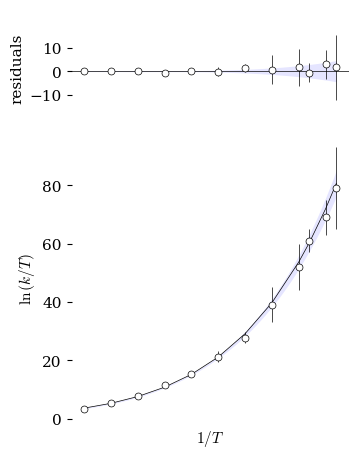

------------------------------------
---- Calc Thermo Params 95% CI -----
------------------------------------
(4.02+/-0.16)e+04
-74+/-5
The change in enthalpy is 48761.10+/-1621.69 kJ/mole
The change in entropy is -61.51+/-5.36 J/mole.K
Calculated k at T = 310 K is 24.05+/-0.55 s^-1


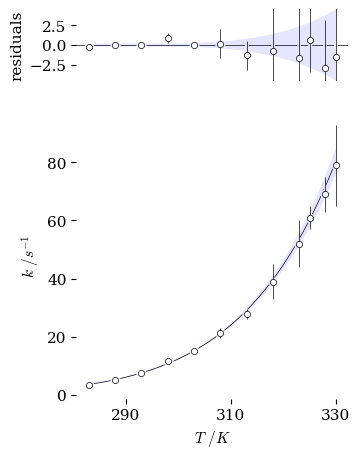

In [31]:
### LMFit

######################
### Read in data set
######################

datafile = "Eryingdata1.csv"   # change this file for new data
#datafile = "Eryingdata2.csv"   # change this file for new data
#datafile = "Eryingdata3.csv"   # change this file for new data
#datafile = "Eryingdata4.csv"   # change this file for new data

data = pd.read_csv(location_data+datafile, 
                 delimiter = ",", 
                 skipinitialspace=True, 
#                 index_col="TEMP(K)", 
                 comment = "#") 
display(data)

######################
### Experimental data with error
######################

temp = data["TEMP(K)"]       # list of temperatures
k_obs = data["Kcat(s-1)"]      # list of observe rate constants (s^-1)
k_obs_err = data["Error(s-1)"]  # list of standard deviations for data

### Convert lists to numpy arrays (enables numpy math tools with these lists)
temp = np.array(temp)
k_obs_u = unp.uarray(k_obs, k_obs_err)   # make an array of ufloat values

### Calculations for Erying plot axes
x = temp
y = unp.nominal_values(k_obs_u) # extract arrays of nominal values and errors
y_err = unp.std_devs(k_obs_u)   # because curve_fit can handle ufloats

######################
### function to be used by curve_fit
######################
def eyring(T, dH, dS):       # function for curve fit. No uncertainty allowed
    
    R = scipy.constants.R
    kb = scipy.constants.k
    h = scipy.constants.h
    kappa = 1

    y = (kappa * kb / h) * T * np.exp(-dH/(R*T)) * np.exp(dS/R)
    return y

def eyring_u(T, dH, dS):     # same function as above but uses uncertainty
                             # to be used when calculating confidence bands.
    R = scipy.constants.R
    kb = scipy.constants.k
    h = scipy.constants.h
    kappa = 1

    y = (kappa * kb / h) * T * unp.exp(-dH/(R*T)) * unp.exp(dS/R)
    return y

### Use curve_fit function  

# load the function f as the model to be fit
mod = lmfit.Model(eyring)       

# state the parameters (use the text strings that we used above in the 
#   function) initial values are also set here
pars = mod.make_params(dH=10000, dS=-10  )     
                                            
# use the .fit method on the model object to perform the curve fit
result = mod.fit(y, pars, T=x, weights=1.0/y_err)   


print("---------- FIT REPORT ------------")
print(result.fit_report())

r,p = scipy.stats.pearsonr(x,y); rsq = r**2
print(f"RSQ = {rsq:0.3f}")
print()

#print("--- PARAMETER CONFIDENCE INTERVALS ----")
print(result.ci_report())
#print()

dH_u = result.uvars['dH']      # collect parameters as uncertain values 
dS_u = result.uvars['dS']

Temp = 310
R = scipy.constants.R
kb = scipy.constants.k
h = scipy.constants.h
kappa = 1

print("\n ------THERMODYNAMIC PARAMETERS - 1 sigma ---------")
print(f"The change in enthalpy is {dH_u:0.2f} J/mole")
print(f"The change in entropy is {dS_u:0.2f} J/mole.K")
print()

## calculate k from Erying plot parameters.
kobs = (kappa * kb / h) * Temp * unp.exp(-dH/(R*Temp)) * unp.exp(dS/R)
print("-------- CHECK FIT ----------")
print(f"calculate k at T={Temp} K is {kobs:0.2f}")

### PLOT

plt.rcdefaults()
style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = location_styles + style
plt.style.use(style_name)

#intercept = result.uvars['b']      # collect parameters as uncertain values 
#slope = result.uvars['m']

fig = plt.figure(figsize = size2)
result.plot(fig = fig,
            fig_kws = {},      # this is a keyword dictionary for figure styles
            xlabel = r"$1/T$",
            ylabel = r"$\ln \left( k/T \right)$",
            yerr = 2*y_err,
            title = " ",
            data_kws ={"color":"black", "linestyle":"None", "linewidth": 0.5,
                       "markerfacecolor": "white", "markeredgecolor":"black", "markersize":5,
                       "markeredgewidth":0.5, "zorder":3},
            fit_kws ={"linewidth": 0.5, "zorder":2},
            ax_res_kws = {},   # 'kws' is 'keyword styles'
            ax_fit_kws = {},
            )
 
ax = fig.axes   # get the axes from the plot (there are two in a list)

ax[1].set_xticks([0.0031,0.0033,0.0035]) # These will be the ticks for both axes

### Confidence band
sigma = 2

x_0 = np.linspace(np.min(x), np.max(x), 100)
y_0 = result.eval(T=x_0)
dely = result.eval_uncertainty(T=x)
dely_0 = result.eval_uncertainty(T=x_0, sigma=sigma)

ax[1].fill_between(x_0, y_0-dely_0, y_0+dely_0, 
                   linewidth=0, color='blue', alpha = 0.1, zorder=1
                   )
ax[0].fill_between(x_0, -dely_0, dely_0, 
                   linewidth=0, color='blue', alpha = 0.1, zorder=1
                   )

### do not show legend 
#fig.legend([])
ax[1].legend([])      # blank legend

plt.tight_layout(pad=2, h_pad=None, w_pad=None, rect=None)
plt.savefig("plots/3F-5.pdf")
plt.show()


print("------------------------------------")
print("---- Calc Thermo Params 95% CI -----")
print("------------------------------------")

dH_ci95 = result.ci_out["dH"][1][1] - result.ci_out["dH"][3][1]
dS_ci95 = result.ci_out["dS"][1][1] - result.ci_out["dS"][3][1]
dH_best = result.ci_out["dH"][3][1]
dS_best = result.ci_out["dS"][3][1]

# I want to use the correlation matrix for the results.uvars parameters
#  but I want to use the 95% confidence interval as the error.

# make correlation matrix from the uvars (note correlation matrix is 
#  different than covariance matrix)

corr_matrix = un.correlation_matrix([result.uvars["dH"], result.uvars["dS"]])

(dH, dS) = un.correlated_values_norm([(dH_best,abs(dH_ci95)),
                                               (dS_best, abs(dS_ci95))],
                                               corr_matrix)

print(slope)
print(intercept)

### calculate thermodynamic parameters
R = scipy.constants.R
kb = scipy.constants.k
h = scipy.constants.h
kappa = 1


print(f"The change in enthalpy is {dH:0.2f} kJ/mole")
print(f"The change in entropy is {dS:0.2f} J/mole.K")

## calculate k from Erying plot parameters.
Temp = 310
kobs = (kappa * kb / h) * Temp * unp.exp(-dH/(R*Temp)) * unp.exp(dS/R)
print(f"Calculated k at T = {Temp} K is {kobs:0.2f} s^-1")




###############################################################################
######################
### Plots - NEW STYLED PLOTTING SECTION
######################

plt.rcdefaults()

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=size2, height_ratios=[1, 4])  

# Settings for plot
ax[1].set(
#          teitle = Title,       
          ylabel=r"$k\ /s^{-1}$ ", 
          xlabel=r"$T\ /K$",                
#          xlim=[0, np.max(x) + np.max(x) * 0.1],                  
#          ylim=[None,None]
       )

### White background graphics
ax[1].scatter(x, y, marker = "o", s = 40, color = "white", zorder = 2)
### Data graphics
ax[1].scatter(x, y, marker = "o", s = 20, 
              color = "white", edgecolors = "black", 
              linewidths=0.5, zorder = 4) 


### calculate y-values using best fit parameters
x_0 = np.linspace(np.min(x),np.max(x),100)       # for plotting from zero
best_fit_y = eyring_u(x_0, dH, dS)     # uncertain array of line fit

# Plot the curve fit line
ax[1].plot(x_0,unp.nominal_values(best_fit_y), 
           marker = None, color = "black", 
           linewidth=0.5, zorder = 0)


######################
#### Create Confidence band upper and lower bounds
######################
sigma = 2

# upper and lower bounds of uncertain kobs as float values
fit_up = unp.nominal_values(best_fit_y) + unp.std_devs(best_fit_y)
fit_dn = unp.nominal_values(best_fit_y) - unp.std_devs(best_fit_y)

# make filled band
ax[1].fill_between(x_0, fit_up, fit_dn, 
                   facecolor="blue", alpha=0.1, zorder = 2,
                   label="confidence interval")

# Add error bars
### White background graphics
ax[1].errorbar(x, y, yerr=y_err*sigma, xerr=None, fmt="None", 
               ecolor="white", elinewidth=1.5, dash_capstyle="round",
               zorder=1)
### Data graphics
ax[1].errorbar(x, y, yerr=y_err*sigma, xerr=None, fmt="None", 
               ecolor="black", elinewidth=0.5, 
             #  capsize=2, capthick=0.5, 
               zorder=3)

ax[1].set_xticks([290,310,330])


######################
### Plot the residuals
######################

# difference between data and line-fit
residuals = y - eyring_u(x, dH.n, dS.n)      

ax[0].set(
#          title = Title,       
          ylabel=r"residuals", 
          xlabel=r"",                
#          xlim=[0, np.max(x) + np.max(x) * 0.1],                  
          ylim=[-np.max(residuals)*5,np.max(residuals)*5]
       )
### White background Graphics
ax[0].scatter(x, residuals, marker = "o", s = 40, color = "white", zorder = 1)
ax[0].errorbar(x, residuals, yerr=y_err*sigma, xerr=None, fmt="None", 
               ecolor="white", elinewidth=3, zorder=1)
### Data graphics
ax[0].scatter(x, residuals, marker = "o", s = 20, 
              color = "white", edgecolors = "black", 
              linewidths=0.5, zorder = 3)
ax[0].errorbar(x, residuals, yerr=y_err*sigma, xerr=None, fmt="None", 
               ecolor="black", elinewidth=0.5, dash_capstyle="projecting",
             #  capsize=2, capthick=0.5, 
               zorder=2)

# make filled band
ax[0].fill_between(x_0, unp.std_devs(best_fit_y) , -unp.std_devs(best_fit_y) , 
                   facecolor="blue", alpha=0.1, zorder = 1,
                   linewidth = 0, label="confidence interval")

### Other elements
ax[0].axhline(0, color='black', linewidth=0.5, zorder = 0) 
ax[0].set_xticks([])


### Output plot
plt.tight_layout(pad=2, h_pad=None, w_pad=None, rect=None)
plt.savefig("plots/3F-5B.pdf")
plt.show()


In [25]:
result.ci_out

{'dH': [(0.9973002039367398, 45948.44258405166),
  (0.9544997361036416, 47139.40928627833),
  (0.6826894921370859, 48014.280784610586),
  (0.0, 48761.09979488822),
  (0.6826894921370859, 49506.65143852526),
  (0.9544997361036416, 50376.85047694863),
  (0.9973002039367398, 51555.99096230445)],
 'dS': [(0.9973002039367398, -70.81645734835607),
  (0.9544997361036416, -66.87489450060463),
  (0.6826894921370859, -63.98184930405324),
  (0.0, -61.513856295391165),
  (0.6826894921370859, -59.05152995553351),
  (0.9544997361036416, -56.179408593924194),
  (0.9973002039367398, -52.29095868761452)]}